In [1]:
from funcx.sdk.client import FuncXClient

In [2]:
fxc = FuncXClient()

you need two endpoints for this one.

In [86]:
epjb = 'a7c14a88-xxxx-41ae-963f-7b419e29e6dd' #jetbot
ep = '21096a36-xxxx-4b61-8f8c-4b7b1e61c22f' #k8s pc'


In [5]:
import time

### Pub-Sub Routing
This demo shows how four funcx instances an communicate streams through a zmq pub-sub routing filter.   The routing filter is a simple program that runs on a server with a "public" IP.  In this case it is a small jetson device and the access is via the local area network.  We have two listeners.  One listener subscribes to messages on channel 5 and the other on channel 3.   We have two "sender" functions that send a stream of messages to the router.  One "Sally" runs on a small server and the other "fred" is invoked from this notebook.   The only difference is that Sally sends a message every 0.2 seconds and Fred sends messages twice as often.   Both alternate messages between channels 3 and 5.  


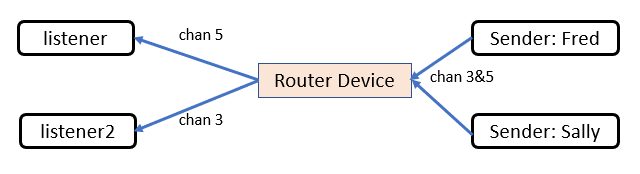

In [49]:
## the listener function has a simple structure.
# it subscribes to the router device on a specific topic and
# then it waits for messages.   For termination it eiter waits for 1000 messages 
# or for a 'Stop' message.   


def zmq_listener(topic):
    import sys
    import zmq

    port = "5560"
    # Socket to talk to server
    context = zmq.Context()
    socket = context.socket(zmq.SUB)
    
    socket.connect ("tcp://10.0.0.6:%s" % port)
    topicfilter = topic
    socket.setsockopt(zmq.SUBSCRIBE, topicfilter)
    items = []
    for update_nbr in range(1000):
        string = socket.recv()
        topic, messagedata = string.split()
        if messagedata == b'Stop':
            items.append('found stop')
            break
        items.append(( topic, messagedata))
    return items


In [50]:
listener = fxc.register_function(zmq_listener)

### launch the listeners

In [78]:
listener_res = fxc.run(b'5', endpoint_id=ep, function_id=listener)
listener_res2 = fxc.run(b'3', endpoint_id=ep, function_id=listener)

#### Senders
There are two senders.   both send messages alternating on channel 3 and 5.   One sender just sends 22 messages and then a stop signal on each channel.   

The other is a stream of 200 messages at half the speed of the first.

In [79]:
def zmq_sender():
    import zmq
    import random
    import sys
    import time

    port = "5559"
    context = zmq.Context()
    socket = context.socket(zmq.PUB)
    socket.connect("tcp://10.0.0.6:%s" % port)
    publisher_id = 'fred'
    topic = '5'
    for i in range(22):
        if topic == '5':
            topic = '3'
        else:
            topic = '5'
        messagedata = "server#%s" % publisher_id+str(i)
        print ("%s %s" % (topic, messagedata))
        socket.send_string("%s %s" % (topic, messagedata))
        time.sleep(.1)
    socket.send_string("%s %s" % ('3',"Stop"))
    socket.send_string("%s %s" % ('5',"Stop"))

def zmq_sender2():
    import zmq
    import random
    import sys
    import time

    port = "5559"
    context = zmq.Context()
    socket = context.socket(zmq.PUB)
    socket.connect("tcp://10.0.0.6:%s" % port)
    publisher_id = 'Sally'
    topic = '5'
    for i in range(200):
        if topic == '5':
            topic = '3'
        else:
            topic = '5'
        messagedata = "server#%s" % publisher_id+str(i)
        print ("%s %s" % (topic, messagedata))
        socket.send_string("%s %s" % (topic, messagedata))
        time.sleep(.2)


#### launch sender2 remotely

In [80]:
sender2 = fxc.register_function(zmq_sender2)

In [81]:
sender2_res = fxc.run(endpoint_id=epjb, function_id=sender2)


In [82]:
fxc.get_task(sender2_res)

{'pending': True, 'status': 'waiting-for-ep'}

### launch sender from the command line in the  notebook

In [83]:
zmq_sender()

3 server#fred0
5 server#fred1
3 server#fred2
5 server#fred3
3 server#fred4
5 server#fred5
3 server#fred6
5 server#fred7
3 server#fred8
5 server#fred9
3 server#fred10
5 server#fred11
3 server#fred12
5 server#fred13
3 server#fred14
5 server#fred15
3 server#fred16
5 server#fred17
3 server#fred18
5 server#fred19
3 server#fred20
5 server#fred21


### observe
when the first sender terminates that kills the two listeners.  notice that they each started to  pick up 'sally' messages at first until 'fred' came in and then it was 2 freds for each sally.


In [84]:
fxc.get_task(listener_res)

{'pending': False,
 'status': 'success',
 'result': [(b'5', b'server#Sally1'),
  (b'5', b'server#Sally3'),
  (b'5', b'server#Sally5'),
  (b'5', b'server#fred1'),
  (b'5', b'server#Sally7'),
  (b'5', b'server#fred3'),
  (b'5', b'server#Sally9'),
  (b'5', b'server#fred5'),
  (b'5', b'server#fred7'),
  (b'5', b'server#Sally11'),
  (b'5', b'server#fred9'),
  (b'5', b'server#fred11'),
  (b'5', b'server#Sally13'),
  (b'5', b'server#fred13'),
  (b'5', b'server#fred15'),
  (b'5', b'server#Sally15'),
  (b'5', b'server#fred17'),
  (b'5', b'server#fred19'),
  (b'5', b'server#Sally17'),
  (b'5', b'server#fred21'),
  'found stop'],
 'completion_t': '1608664549.0693378'}

In [85]:
fxc.get_task(listener_res2)

{'pending': False,
 'status': 'success',
 'result': [(b'3', b'server#Sally2'),
  (b'3', b'server#Sally4'),
  (b'3', b'server#Sally6'),
  (b'3', b'server#fred2'),
  (b'3', b'server#Sally8'),
  (b'3', b'server#fred4'),
  (b'3', b'server#fred6'),
  (b'3', b'server#Sally10'),
  (b'3', b'server#fred8'),
  (b'3', b'server#fred10'),
  (b'3', b'server#Sally12'),
  (b'3', b'server#fred12'),
  (b'3', b'server#fred14'),
  (b'3', b'server#Sally14'),
  (b'3', b'server#fred16'),
  (b'3', b'server#fred18'),
  (b'3', b'server#Sally16'),
  (b'3', b'server#fred20'),
  'found stop'],
 'completion_t': '1608664549.0720673'}